# Color profiling of corn ears
Source1: https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

Source2: https://realpython.com/python-opencv-color-spaces/

# Import libraries

The type of this input is <class 'numpy.ndarray'>
Shape: (4032, 3024, 3)


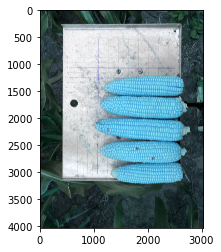

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline

image = cv2.imread('./data/IMG_8342.jpg')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

## Output
# The type of this input is <class 'numpy.ndarray'>
# Shape: (3161, 2476, 3)

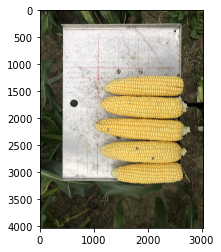

In [4]:
# OpenCV reads image in the sequence Blue Green Red (BGR). 
# Thus, to view the actual image we need to convert the rendering 
# to Red Green Blue (RGB).
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

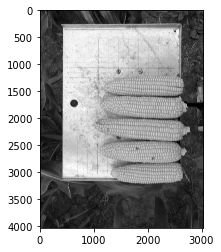

In [5]:
# You may also convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

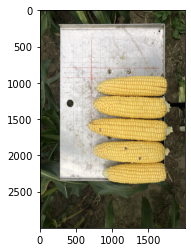

In [6]:
# Or resize the image
resized_image = cv2.resize(image, (2000, 3000))
plt.imshow(resized_image)

# Mask the Image

Text(0.5, 1.0, 'Masked Image')

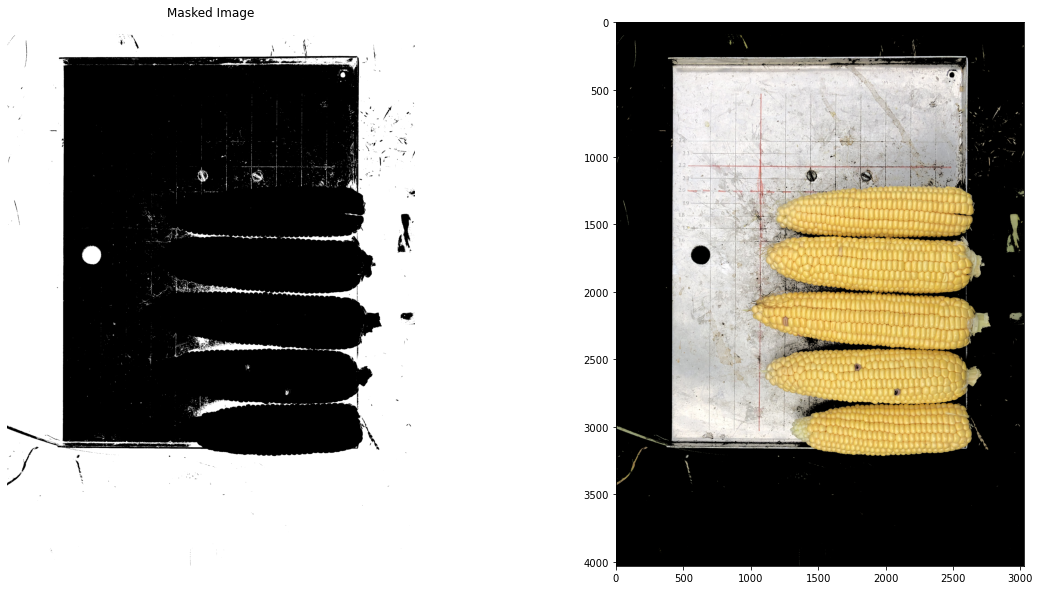

In [19]:
# Trick to trim off top of dish
rmax=133
background_mask = image[:,:,0] < rmax 
background_mask[0:90,:] = 1

# Remove the background_mask from the original image
forground_im = image.copy()
forground_im[background_mask,:] = 0

#Plot the results side-by-side with the original image
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.imshow(background_mask, cmap='gray')
ax1.set_title('Background Mask')
ax1.axis('off')
ax2.imshow(forground_im)
ax1.set_title('Masked Image')

# HSV

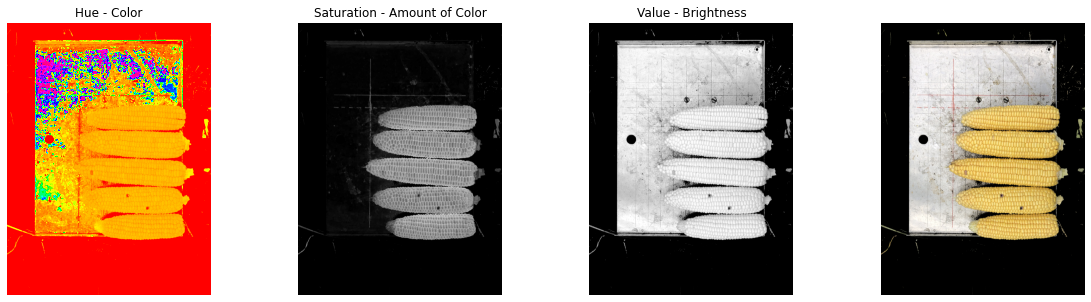

In [22]:
im = forground_im
#Code snipit from previous class to show image as HSV
import colorsys
import matplotlib.colors as colors

hsv = colors.rgb_to_hsv(im)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))
ax1.imshow(hsv[:,:,0], cmap='hsv')
ax1.set_title('Hue - Color')
ax1.set_axis_off()

ax2.imshow(hsv[:,:,1],cmap='gray',vmin=0, vmax=1)
ax2.set_title('Saturation - Amount of Color')
ax2.set_axis_off()

ax3.imshow(hsv[:,:,2],cmap='gray')
ax3.set_title('Value - Brightness')
ax3.set_axis_off()

ax4.imshow(im)
ax4.set_axis_off()

# Saturation thresholds
### Since we want to know t the distribution of kernels color, we should not set a threshold in 'v'. From the figure above, the best idea is setting threshold for 's'.

(-0.5, 3023.5, 4031.5, -0.5)

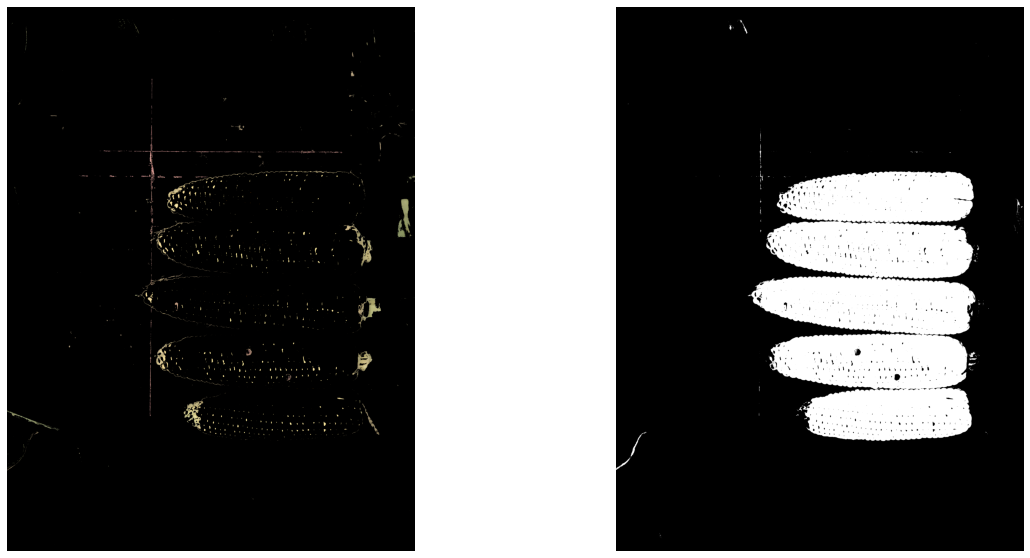

In [57]:
# Code to visualize the segmentation from above
hsv = colors.rgb_to_hsv(im)
smin= 0.4
smax= 1.0
s1 = hsv[:,:,1] > smin
s2 = hsv[:,:,1] < smax


binary_image = s1 & s2


im_background = im.copy()
im_background[binary_image] = 0

#Plot the results side-by-side with the original image
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.imshow(im_background)
ax1.axis('off')
ax2.imshow(binary_image, cmap='gray')
ax2.axis('off')

# Crop Image

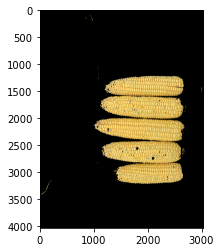

In [58]:
# modify x, y, height, and width values
crop_image = forground_im
crop_image[:,:,0] = forground_im[:,:,0] * binary_image
crop_image[:,:,1] = forground_im[:,:,1] * binary_image
crop_image[:,:,2] = forground_im[:,:,2] * binary_image
#cv2.imshow("cropped", crop_image)
#cv2.waitKey(0)
plt.imshow(crop_image)

# Color Identification

In [59]:
# RGB to Hex Conversion
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

# read in an image into RGB space
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return imag

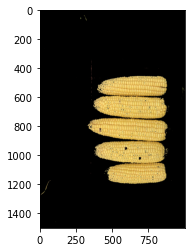

In [82]:
# Extract colors from the image
# Resizing to a smaller size but we do so to lessen the pixels 
# which will reduce the time needed to extract the colors from 
# the image.
modified_image = cv2.resize(crop_image, (1000, 1500), interpolation = cv2.INTER_AREA)
plt.imshow(modified_image)
plt.savefig('color_mask.png')

In [83]:
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

KMeans algorithm creates clusters based on the supplied count of clusters. In our case, it will form clusters of colors and these clusters will be our top colors. We then fit and predict on the same image to extract the prediction into the variable labels.

We use Counter to get count of all labels. To find the colors, we use clf.cluster_centers_. The ordered_colors iterates over the keys present in count, and then divides each value by 255. We could have directly divided each value by 255 but that would have disrupted the order.

Next, we get the hex and rgb colors. As we divided each color by 255 before, we now multiply it by 255 again while finding the colors. If show_chart is True, we plot a pie chart with each pie chart portion defined using count.values(), labels as hex_colors and colors as ordered_colors. We finally return the rgb_colors which we’ll use at a later stage.

In [84]:
# KMeans clustering of colors
number_of_colors = 15 # total colors we want to extract

clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)
counts = Counter(labels)
center_colors = clf.cluster_centers_

# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]


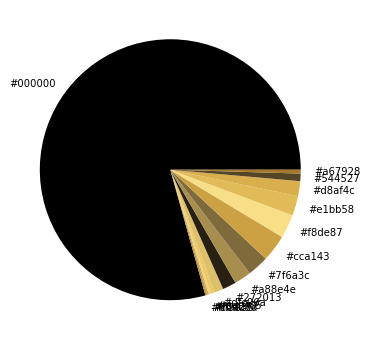

In [85]:
plt.figure(figsize = (8, 6))
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
plt.show()

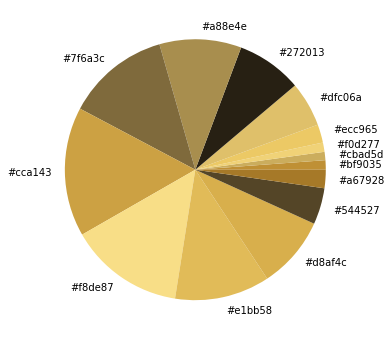

In [88]:
# remove background
back_idx = np.array(hex_colors) != '#000000'
counts_value = np.array(list(counts.values()))[back_idx]
hex_col = np.array(hex_colors)[back_idx]

# Pie chart
plt.figure(figsize = (8, 6))
plt.pie(counts_value, labels=hex_col, colors=hex_col)
plt.savefig('pie.png')
plt.show()